In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os, copy
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random
from tqdm import tqdm

def seed_everything(seed=42):
    """
    재현성을 위해 Python, NumPy, PyTorch의 Seed를 고정합니다.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
# =====================================================================
# 1. UCI HAR 데이터 로더 (변경 없음)
# =====================================================================
class UCIHARDataset(Dataset):
    def __init__(self, data_dir, train=True):
        subset = 'train' if train else 'test'
        signals = []
        signal_types = ['body_acc_x', 'body_acc_y', 'body_acc_z',
                        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
                        'total_acc_x', 'total_acc_y', 'total_acc_z']
        for signal in signal_types:
            filename = os.path.join(data_dir, subset, 'Inertial Signals', f'{signal}_{subset}.txt')
            with open(filename, 'r') as f:
                data = np.loadtxt(f)
            signals.append(data)
        self.X = np.stack(signals, axis=1)
        label_file = os.path.join(data_dir, subset, f'y_{subset}.txt')
        with open(label_file, 'r') as f:
            self.y = np.loadtxt(f, dtype=np.int32) - 1
        print(f"Loaded {subset} data: X shape={self.X.shape}, y shape={self.y.shape}")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]

In [3]:
# =====================================================================
# 2. 1D-CBAM (변경 없음)
# =====================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))
        max_out = self.fc(self.max_pool(x).squeeze(-1))
        out = self.sigmoid(avg_out + max_out).unsqueeze(-1)
        return x * out

class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out

class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [4]:
# =====================================================================
# 3. Contrastive Prototype Loss
# =====================================================================
class ContrastivePrototypeLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, prototypes, labels):
        """
        Contrastive Loss between features and prototypes

        Args:
            features: (B, D) - 샘플 특징
            prototypes: (N_class, D) - 클래스별 프로토타입
            labels: (B,) - 레이블

        Returns:
            loss: contrastive loss
        """
        # L2 정규화
        features = F.normalize(features, dim=1)
        prototypes = F.normalize(prototypes, dim=1)

        # 유사도 계산 (B, N_class)
        logits = torch.matmul(features, prototypes.t()) / self.temperature

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)

        return loss

In [5]:
# =====================================================================
# 4. CrossFormer with Contrast Prototypes
# =====================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self, dim, n_prototypes=6, n_heads=4, mlp_ratio=2.0, dropout=0.1,
                 initial_prototypes=None):
        super().__init__()
        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))
        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print(">>> [Main Model] Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print(">>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.")
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, hidden_dim), nn.GELU(), nn.Dropout(dropout),
                                 nn.Linear(hidden_dim, dim), nn.Dropout(dropout))
        self.proto_proj = nn.Sequential(nn.Linear(dim, dim), nn.GELU(), nn.Linear(dim, dim))

    def forward(self, x, return_proto_features=False, skip_cross_attention=False):
        B, T, C = x.shape
        attn_weights = None
        if not skip_cross_attention:
            normalized_prototypes = F.normalize(self.prototypes, dim=1)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)
            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out
        x = x + self.mlp(self.norm3(x))
        if return_proto_features:
            proto_features = x.mean(dim=1)
            proto_features = self.proto_proj(proto_features)
            return x, proto_features, attn_weights
        return x

In [6]:
# =====================================================================
# 5. 메인 모델: CrossFormer + 1D-CBAM + Contrast Prototype
# =====================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    def __init__(self, in_channels=9, seq_len=128, embed_dim=64, reduced_dim=32,
                 n_classes=6, n_prototypes=6, n_heads=8, kernel_size=7, dropout=0.1,
                 temperature=0.07, initial_prototypes=None, use_cbam=True,
                 use_crossformer=True, use_contrast=True, use_dim_reduction=False):
        super().__init__()
        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(embed_dim), nn.GELU(), nn.Dropout(dropout)
        )
        if self.use_cbam:
            self.cbam = CBAM1D(embed_dim, reduction=8, kernel_size=kernel_size)

        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim, n_prototypes=n_prototypes, n_heads=n_heads,
                mlp_ratio=2.0, dropout=dropout, initial_prototypes=initial_prototypes
            )
        else:
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim, nhead=n_heads, dim_feedforward=int(working_dim * 2),
                dropout=dropout, batch_first=True
            )
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes)
        )
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)

    def forward(self, x, labels=None, return_contrast_loss=False):
        x = self.embedding(x)
        if self.use_cbam:
            x = self.cbam(x)
        x = x.transpose(1, 2).contiguous()
        if self.use_dim_reduction:
            x = self.dim_reduce(x)
        
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True)
            else:
                x = self.crossformer(x, return_proto_features=False)
        else:
            x = self.self_attn(x)
            
        if self.use_dim_reduction:
            x = self.dim_restore(x)
            
        x = x.transpose(1, 2).contiguous()
        x = self.pool(x).squeeze(-1)
        logits = self.classifier(x)
        
        if return_contrast_loss and self.use_contrast and proto_features is not None and labels is not None:
            contrast_loss = self.contrast_loss(proto_features, self.crossformer.prototypes, labels)
            return logits, contrast_loss
        return logits

In [7]:
# =====================================================================
# 6. get_mean_prototypes
# =====================================================================
def get_mean_prototypes(train_full_dataset, device, config):
    print("Calculating initial prototypes from mean features...")

    temp_model = ContrastCrossFormerCBAM_HAR(
        embed_dim=config['embed_dim'], reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'], kernel_size=config['kernel_size'],
        dropout=config['dropout'], use_cbam=True, use_crossformer=True, 
        use_contrast=False, use_dim_reduction=config['use_dim_reduction']
    ).to(device)
    temp_model.eval()

    temp_loader = DataLoader(train_full_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=0)
    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)
            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)
            x = x.transpose(1, 2).contiguous()
            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)
            x = temp_model.crossformer(x, skip_cross_attention=True)
            x = x.transpose(1, 2).contiguous()
            pooled_features = temp_model.pool(x).squeeze(-1)
            all_features.append(pooled_features.cpu())
            all_labels.append(batch_y.cpu())

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    working_dim = config['reduced_dim'] if config['use_dim_reduction'] else config['embed_dim']
    mean_prototypes = torch.zeros(temp_model.classifier[-1].out_features, working_dim)

    for i in range(len(mean_prototypes)):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(working_dim)

    print(f"Initial prototypes calculated. Shape: {mean_prototypes.shape}")
    return mean_prototypes.to(device)

In [8]:
# =====================================================================
# 7. 학습 및 평가 (Contrastive Loss 포함)
# =====================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_contrast=True, contrast_weight=0.5):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_contrast_loss = 0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss + contrast_weight * contrast_loss
            total_contrast_loss += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_loss = total_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    avg_contrast_loss = total_contrast_loss / len(dataloader) if total_contrast_loss > 0 else 0
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_preds, all_labels

In [9]:
# =====================================================================
# 8. 시각화 
# =====================================================================

# 활동 레이블 정의 (그래프에 사용)
ACTIVITY_LABELS = [
    'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING'
]

def plot_classification_results(y_true, y_pred):
    """
    Classification Report를 출력하고, 정규화된 Confusion Matrix를 시각화합니다.
    Args:
        y_true (list or np.array): 실제 레이블.
        y_pred (list or np.array): 모델의 예측 레이블.
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=ACTIVITY_LABELS, digits=4))

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    print("\n" + "="*80)
    print("Normalized Confusion Matrix")
    print("="*80)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def visualize_tsne(model, dataloader, device):
    """
    학습된 모델을 사용하여 데이터의 특징을 t-SNE로 시각화합니다.
    Args:
        model: 학습이 완료된 모델.
        dataloader: 시각화할 데이터가 담긴 DataLoader (주로 test_loader).
        device: 'cuda' 또는 'cpu'.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader, desc="Extracting features for t-SNE"):
            batch_x = batch_x.to(device)

            # --- 최종 분류 레이어 직전의 특징 벡터 추출 ---
            x = model.embedding(batch_x)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2)
            if model.use_dim_reduction:
                x = model.dim_reduce(x)
            
            x = model.crossformer(x, skip_cross_attention=False)
            
            if model.use_dim_reduction:
                x = model.dim_restore(x)

            pooled_features = x.mean(dim=1) # Global Average Pooling
            # -----------------------------------------------

            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # t-SNE 실행 (데이터가 많을 경우 시간이 소요될 수 있습니다)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=2000, init='pca', learning_rate='auto')
    tsne_features = tsne.fit_transform(all_features)

    # 시각화
    df = pd.DataFrame(tsne_features, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in all_labels]

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of Feature Space', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Activity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Device: cuda
Loading UCI HAR Dataset from: C://Users/park9/CBAM_HAR/data
Loaded train data: X shape=(7352, 9, 128), y shape=(7352,)
Loaded test data: X shape=(2947, 9, 128), y shape=(2947,)
Train: 5881, Validation: 1471, Test: 2947
Calculating initial prototypes from mean features...
>>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 58/58 [00:00<00:00, 121.06it/s]


Initial prototypes calculated. Shape: torch.Size([6, 64])

Training with config: {'DATA_DIR': 'C://Users/park9/CBAM_HAR/data', 'BATCH_SIZE': 128, 'EPOCHS': 100, 'SEED': 42, 'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.0001, 'embed_dim': 64, 'reduced_dim': 32, 'n_heads': 8, 'kernel_size': 11, 'dropout': 0.1, 'use_cbam': True, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False, 'temperature': 0.05, 'contrast_weight': 0.3}
>>> [Main Model] Prototypes initialized with calculated mean features.
Parameters: 71,068


  Epoch [10/100] Train Loss: 0.1575 | Val Acc: 0.9640


  Epoch [20/100] Train Loss: 0.1013 | Val Acc: 0.9660


  Epoch [30/100] Train Loss: 0.0708 | Val Acc: 0.9660


  Epoch [40/100] Train Loss: 0.0433 | Val Acc: 0.9830


  Epoch [50/100] Train Loss: 0.0357 | Val Acc: 0.9884


  Epoch [60/100] Train Loss: 0.0380 | Val Acc: 0.9878


  Epoch [70/100] Train Loss: 0.0264 | Val Acc: 0.9857


  Epoch [80/100] Train Loss: 0.0194 | Val Acc: 0.9871


  Epoch [90/100] Train Loss: 0.0192 | Val Acc: 0.9898


  Epoch [100/100] Train Loss: 0.0184 | Val Acc: 0.9891

✓ Training Complete!
  Best Val Acc: 0.9905 @ epoch 77
  Final Test (Best-VAL ckpt): Acc=0.9688 | F1=0.9683

Classification Report
                    precision    recall  f1-score   support

           WALKING     0.9980    0.9940    0.9960       496
  WALKING_UPSTAIRS     0.9872    0.9851    0.9862       471
WALKING_DOWNSTAIRS     0.9812    0.9952    0.9882       420
           SITTING     0.9747    0.8615    0.9146       491
          STANDING     0.9220    0.9774    0.9489       532
            LAYING     0.9606    1.0000    0.9799       537

          accuracy                         0.9688      2947
         macro avg     0.9706    0.9689    0.9690      2947
      weighted avg     0.9695    0.9688    0.9683      2947


Normalized Confusion Matrix


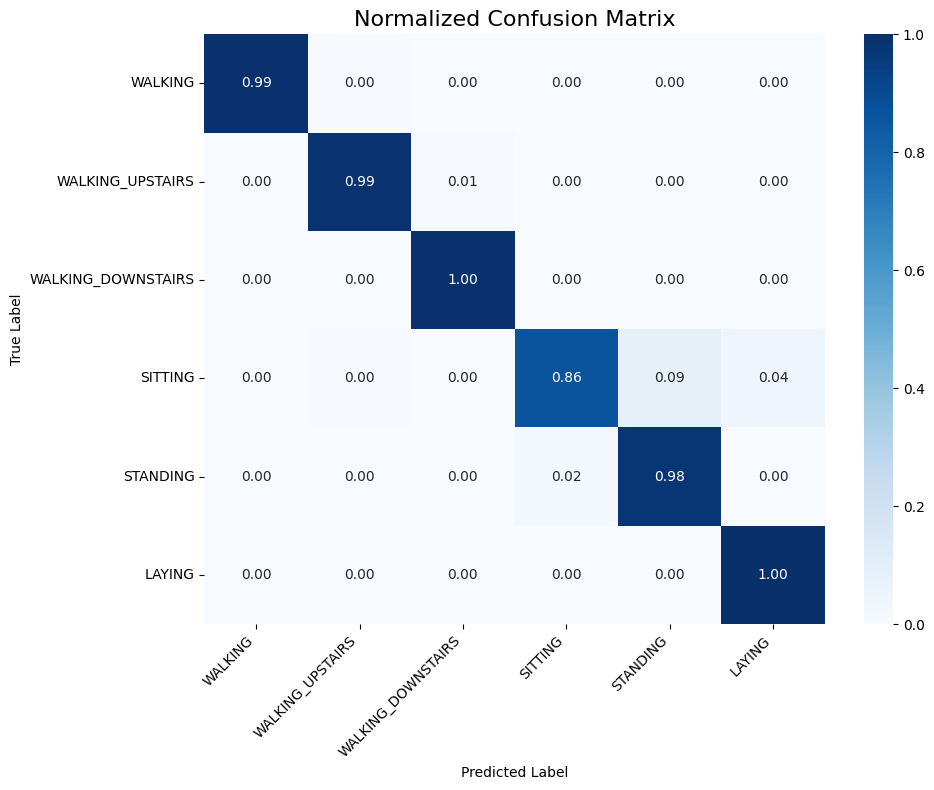


Generating t-SNE visualization...


Extracting features for t-SNE: 100%|██████████| 24/24 [00:00<00:00, 149.69it/s]


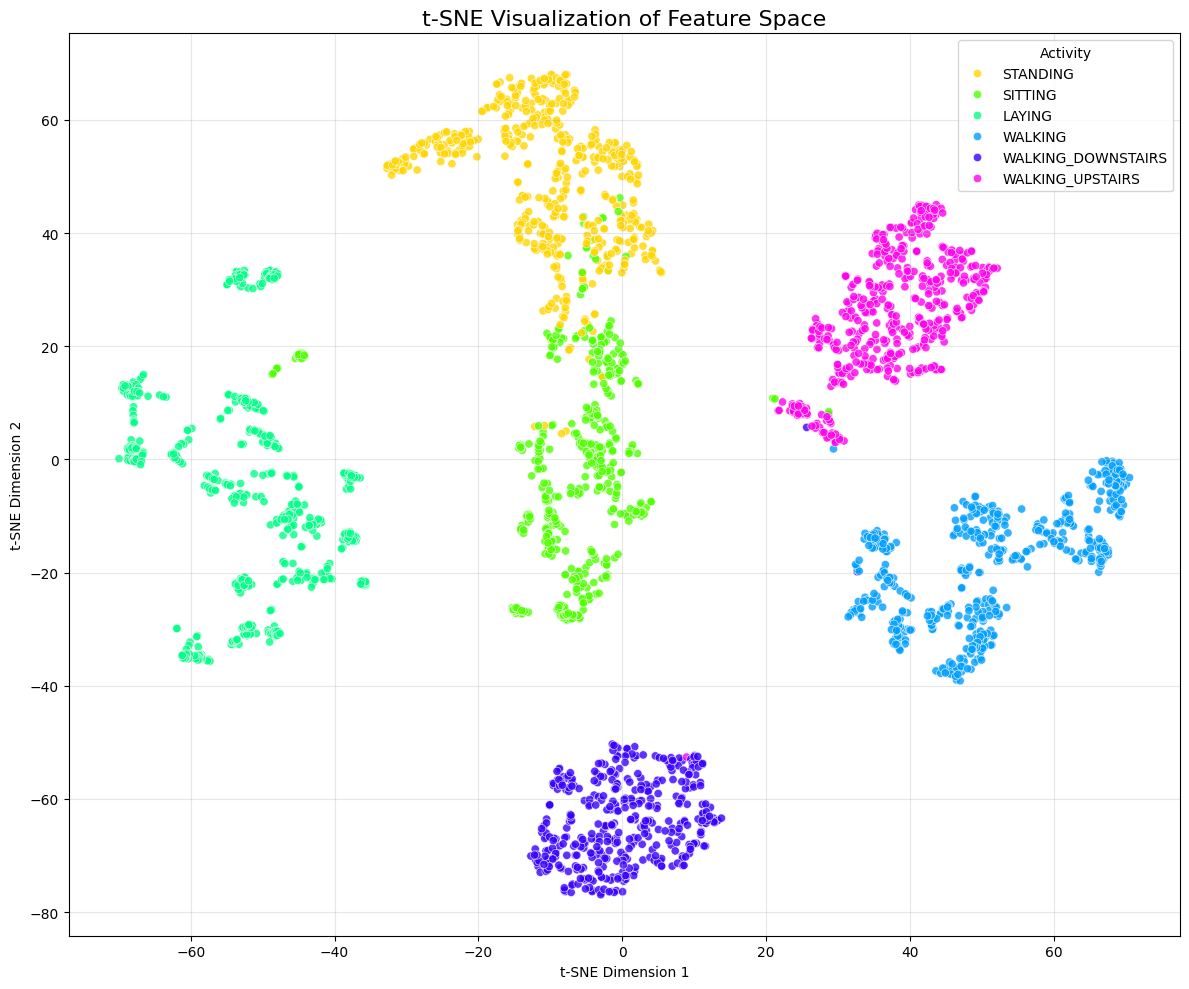


ALL PROCESSES COMPLETED!


In [10]:
# =====================================================================
# 9. 메인 실행
# =====================================================================
def main():
    # === 1. 모든 실험 설정을 여기서 관리합니다 ===
    config = {
        # 데이터 및 학습 설정
        'DATA_DIR': 'C://Users/park9/CBAM_HAR/data',
        'BATCH_SIZE': 128,
        'EPOCHS': 100,
        'SEED': 42,
        'LEARNING_RATE': 5e-4,
        'WEIGHT_DECAY': 1e-4,

        # 모델 아키텍처 설정 (F1 0.9666 모델 기준)
        'embed_dim': 64,
        'reduced_dim': 32,
        'n_heads': 8,
        'kernel_size': 11,
        'dropout': 0.1,
        
        # 컴포넌트 활성화 스위치
        'use_cbam': True,
        'use_crossformer': True,
        'use_contrast': True,
        'use_dim_reduction': False,
        
        # Loss 관련 하이퍼파라미터 (F1 0.9597 모델 기준)
        'temperature': 0.05,
        'contrast_weight': 0.3,
    }
    # ============================================

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed_everything(config['SEED'])

    print(f"Device: {DEVICE}")
    print(f"Loading UCI HAR Dataset from: {config['DATA_DIR']}")

    # 데이터 로드 및 분할
    train_full_dataset = UCIHARDataset(config['DATA_DIR'], train=True)
    test_dataset = UCIHARDataset(config['DATA_DIR'], train=False)
    train_size = int(0.8 * len(train_full_dataset))
    val_size = len(train_full_dataset) - train_size
    train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size],
                                               generator=torch.Generator().manual_seed(config['SEED']))
    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    # 데이터 로더 생성
    g = torch.Generator().manual_seed(config['SEED'])
    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True,
                              worker_init_fn=seed_worker, generator=g, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False,
                            worker_init_fn=seed_worker, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False,
                             worker_init_fn=seed_worker, num_workers=0)
    
    # 평균 프로토타입 계산 (이제 config를 통째로 전달)
    initial_prototypes = get_mean_prototypes(train_full_dataset, DEVICE, config)

    print("\n" + "="*80)
    print(f"Training with config: {config}")
    print("="*80)

    # 모델 생성 (config 딕셔너리의 값들을 사용)
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=9, seq_len=128, n_classes=6, n_prototypes=6,
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'],
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=initial_prototypes,
        use_cbam=config['use_cbam'],
        use_crossformer=config['use_crossformer'],
        use_contrast=config['use_contrast'],
        use_dim_reduction=config['use_dim_reduction']
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")

    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.5, 1.2, 1.0], device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['EPOCHS'])

    # 학습 루프
    history = []
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    for epoch in range(config['EPOCHS']):
        train_results = train_epoch(
            model, train_loader, criterion, optimizer, DEVICE,
            use_contrast=config['use_contrast'], 
            contrast_weight=config['contrast_weight']
        )
        val_results = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()
        
        train_loss, _, _, train_acc, train_f1 = train_results
        val_loss, val_acc, val_f1, _, _ = val_results
        
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss, 'train_acc': train_acc, 'train_f1': train_f1,
            'val_loss': val_loss, 'val_acc': val_acc, 'val_f1': val_f1
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1:2d}/{config['EPOCHS']}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # 최종 테스트 및 시각화
    assert best_state is not None
    model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE)

    print(f"\n✓ Training Complete!")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(f"  Final Test (Best-VAL ckpt): Acc={test_acc:.4f} | F1={test_f1:.4f}")

    plot_classification_results(test_labels, test_preds)
    visualize_tsne(model, test_loader, DEVICE)

    print("\n" + "="*80)
    print("ALL PROCESSES COMPLETED!")
    print("="*80)

if __name__ == '__main__':
    main()